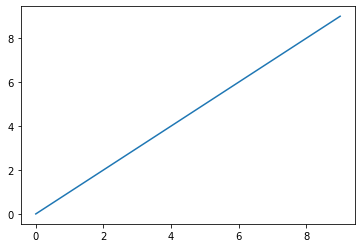

In [1]:
import shutil, os
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(10))

In [2]:
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from inference import *
from detectron2.utils.visualizer import Visualizer
import cv2
from PIL import Image

try:
    DatasetCatalog.register("rpd_valid", grab_valid)
except:
    print('Already registered.')
    #do nothing
try:
    DatasetCatalog.register("rpd_train", grab_train)
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_valid").thing_classes = ["rpd"]
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_train").thing_classes = ["rpd"]   
except:
    print('Already registered.')
    #do nothing

In [3]:
#predict
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output/model_0005999.pth",
                     "MODEL.ROI_HEADS.NMS_THRESH_TEST",".01",
                     "MODEL.ROI_HEADS.SCORE_THRESH_TEST",".001"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output/model_0005999.pth


In [4]:
#build model
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
model.eval(); #set model in evaluation mode

In [5]:
from detectron2.data import build_detection_test_loader
myloader = build_detection_test_loader(cfg,"rpd_valid")

In [6]:
from detectron2.evaluation import COCOEvaluator
myeval = COCOEvaluator("rpd_valid",tasks={'bbox'},output_dir = 'output/results')

Using previously cached COCO format annotations at 'output/results/rpd_valid_coco_format.json'. You need to clear the cache file if your dataset has been modified.


In [7]:
from detectron2.evaluation import inference_on_dataset
eval_result = inference_on_dataset(model,myloader,myeval)

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

In [8]:
eval_result

OrderedDict([('bbox',
              {'AP': 18.428953175761386,
               'AP50': 51.617504189033525,
               'AP75': 7.277554352888062,
               'APs': 18.867167410498595,
               'APm': 0.0,
               'APl': nan})])

In [7]:
cocoDt = myeval._coco_api.loadRes(os.path.join(myeval._output_dir,'coco_instances_results.json'))


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


In [8]:
MetadataCatalog.get('rpd_valid').json_file

'output/results/rpd_valid_coco_format.json'

In [54]:
from pycocotools.cocoeval import COCOeval
mycoco = COCOeval(myeval._coco_api,cocoDt,iouType ='bbox')

In [55]:
mycoco.params.iouThrs = np.arange(.10,.6,.1)
#mycoco.params.recThrs = [0,.5,.75,1]
mycoco.params.maxDets = [100]
#mycoco.params.imgIds=[imgId]
mycoco.params.areaRng = [[0, 10000000000.0]]

mycoco.evaluate()
mycoco.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).


(5, 101, 1, 1, 1)


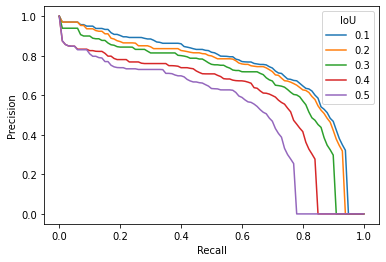

In [56]:
print(mycoco.eval['precision'].shape) #[T,R,K,A,M] parameter dims
# "imgIds": [all] N img ids to use for evaluation 
# "catIds": [all] K cat ids to use for evaluation 
# "iouThrs": [.5:.05:.95] T=10 IoU thresholds for evaluation #this many PR curves to average over
# "recThrs": [0:.01:1] R=101 recall thresholds for evaluation #count precision at these points on curve
# "areaRng": [all,small,medium,large] A=4 area ranges for evaluation 
# "maxDets": [1 10 100] M=3 thresholds on max detections per image
pr = mycoco.eval['precision'][:, #iouthresh
                         :, #recall level
                         0, #catagory
                         0, #area range
                         0] #max detections per image
rc = mycoco.params.recThrs
iou = mycoco.params.iouThrs

for i in range(len(iou)):
    plt.plot(rc,pr[i],label = '{:.2}'.format(iou[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(title='IoU')

Number of images: 1176


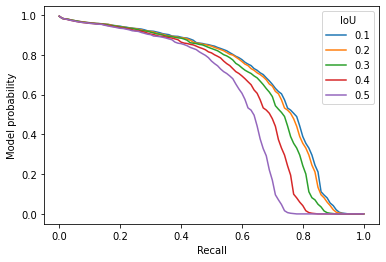

In [57]:

scores = mycoco.eval['scores'][:,:,0,0,0]
#print('Scores:',scores)
print('Number of images:',len(mycoco.params.imgIds))
plt.figure()
for i in range(len(iou)):
    plt.plot(rc,scores[i],label = '{:.2}'.format(iou[i]))
plt.ylabel('Model probability')
plt.xlabel('Recall')
plt.legend(title='IoU')
#print(rc)

In [49]:
#FP rate, 1 RPD in image = FP
fpr = np.zeros((len(iou),len(rc)))
for i in range(len(iou)):
    for j,s in enumerate(scores[i]):
        ng = 0
        fp = 0
        for el in mycoco.evalImgs:
            if el is None:
                ng=ng+1
            elif len(el['gtIds'])==0:
                ng=ng+1
                if (np.array(el['dtScores']) >s).sum() > 0:
                    fp=fp+1
            else:
                continue
        fpr[i,j] = fp/ng
    plt.plot(rc,fpr[i],label = '{:.2}'.format(iou[i]))
plt.xlabel('Recall')
plt.ylabel('FP scan rate')
plt.legend(title='IoU')              

ZeroDivisionError: division by zero

In [16]:
data = DatasetCatalog.get('rpd_valid')

In [50]:
imgId = '101109_OD_oct-002.png'
imgId = '101109_OD_oct-003.png'
imgId = '101109_OD_oct-009.png'
imgId = '101109_OD_oct-007.png'
#imgId = '101109_OD_oct-013.png'
imgId = '101113_OS_oct-039.png'
gt_data = next(item for item in data if (item['image_id'] == imgId))
next(item for item in mycoco.evalImgs if (item['image_id'] == imgId))
#mycoco.evalImgs

{'image_id': '101113_OS_oct-039.png',
 'category_id': 0,
 'aRng': [0, 10000000000.0],
 'maxDet': 100,
 'dtIds': [879, 880, 881, 882, 883, 884, 885, 886, 887, 888],
 'gtIds': [265, 266, 267, 268, 269],
 'dtMatches': array([[  0., 268., 265.,   0., 269.,   0., 266.,   0., 267.,   0.],
        [  0., 268.,   0., 265., 269.,   0., 266.,   0.,   0., 267.],
        [  0., 268.,   0.,   0., 269.,   0., 266.,   0.,   0.,   0.],
        [  0., 268.,   0.,   0., 269.,   0., 266.,   0.,   0.,   0.],
        [  0., 268.,   0.,   0., 269.,   0.,   0.,   0.,   0.,   0.]]),
 'gtMatches': array([[881., 885., 887., 880., 883.],
        [882., 885., 888., 880., 883.],
        [  0., 885.,   0., 880., 883.],
        [  0., 885.,   0., 880., 883.],
        [  0.,   0.,   0., 880., 883.]]),
 'dtScores': [0.9872186183929443,
  0.9671587347984314,
  0.965303361415863,
  0.9593245387077332,
  0.9186343550682068,
  0.9156369566917419,
  0.6493021249771118,
  0.6334981918334961,
  0.5036636590957642,
  0.133647

(496, 1024, 3)


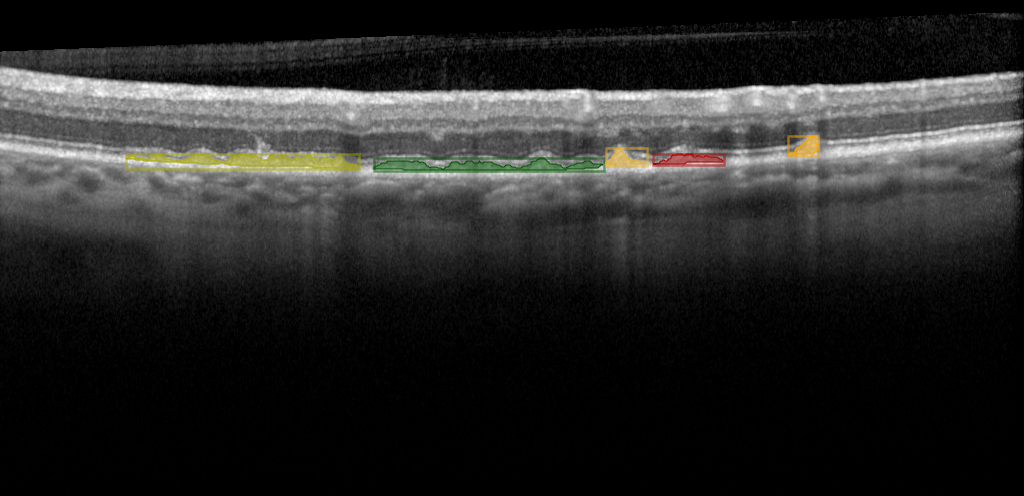

In [42]:
dat = gt_data #gt
im = cv2.imread(dat['file_name']) #input to model
bboxes = [ddict['bbox'] for ddict in dat['annotations']]
BBoxes = detectron2.structures.Boxes(bboxes)
BBoxes = detectron2.structures.BoxMode.convert(BBoxes.tensor,from_mode=1,to_mode=0) #1= XYXY, 2 = XYWH
segs = [ddict['segmentation'] for ddict in dat['annotations']]

v = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
result_image = v.overlay_instances(boxes=BBoxes,masks=segs).get_image()
img = Image.fromarray(result_image)
print(im.shape)
img

In [43]:
pred = DefaultPredictor(cfg)
outputs = pred(im)["instances"].to("cpu")
#outputs

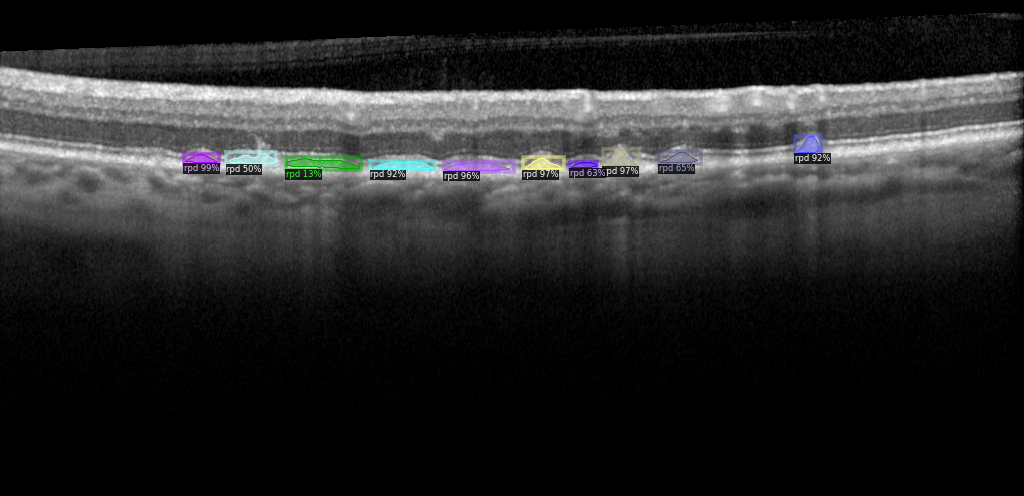

In [44]:
v2 = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
v2._default_font_size = 14
result_model = v2.draw_instance_predictions(outputs).get_image()
img_model = Image.fromarray(result_model)
img_model

In [45]:
mycoco.computeIoU(imgId,0)

array([[0.        , 0.        , 0.09845121, 0.        , 0.        ],
       [0.00221783, 0.        , 0.        , 0.69505546, 0.        ],
       [0.16930946, 0.        , 0.        , 0.        , 0.        ],
       [0.21481612, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.63346291],
       [0.20094785, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.48540383, 0.        , 0.        , 0.        ],
       [0.06297196, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.15377955, 0.        , 0.        ],
       [0.        , 0.        , 0.24450169, 0.        , 0.        ]])